# Первичный анализ данных
**Датасет** - для работы были выбраны данные о лучших игроках недели в NBA, данные взяты с платформы [kaggle](https://www.kaggle.com/datasets/jacobbaruch/nba-player-of-the-week). 

**Цели работы**:
    
1) Изучить зависимость получения звания игрока недели от биологических параметров игроков, от их позиции и от их опыта. Сформулировать гипотезы, исходя из наблюдений, и проверить их
    
2) Существует мнение экспертов, что современный баскетбол уходит от силовой манеры игры к более техничной с обилием дальних бросков. То есть должна быть тенденция, что теперь реже тяжелые, рослые игроки получают звание лучшего на этой неделе

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib
import datetime
from scipy import stats

In [2]:
sns.set_style("darkgrid")
font =  {
            'family': 'DejaVu Sans',
            'weight': 'normal',
            'size'  :  14
        }

matplotlib.rc('font', **font)

In [3]:
df = pd.read_csv("NBA_player_of_the_week.csv")

In [4]:
df.sample(5)

,Player,Team,Conference,Date,Position,Height,Weight,Age,Draft Year,Seasons in league,Season,Season short,Pre-draft Team,Real_value,Height CM,Weight KG,Last Season
294,Jordan Crawford,Boston Celtics,East,"Dec 9, 2013",G,6'5,195,25,2010,3,2013-2014,2014,Xavier,0.5,196,88,0
353,Al Jefferson,Utah Jazz,West,"Apr 23, 2012",FC,6'10,289,27,2004,7,2011-2012,2012,Prentiss High School (Mississippi),0.5,208,131,0
839,Vince Carter,Toronto Raptors,East,"Nov 11, 2001",SF,6'6,220,25,1998,3,2001-2002,2002,North Carolina,0.5,198,99,0
88,LeBron James,Cleveland Cavaliers,East,"Mar 19, 2018",F,6'8,250,33,2003,14,2017-2018,2018,St. Vincent St. Mary High School (Ohio),0.5,203,113,0
96,Andre Drummond,Detroit Pistons,East,"Feb 5, 2018",C,6'11,279,24,2012,5,2017-2018,2018,Connecticut,0.5,211,126,0


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1344 entries, 0 to 1343
Data columns (total 17 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Player             1344 non-null   object 
 1   Team               1344 non-null   object 
 2   Conference         843 non-null    object 
 3   Date               1344 non-null   object 
 4   Position           1344 non-null   object 
 5   Height             1344 non-null   object 
 6   Weight             1344 non-null   int64  
 7   Age                1344 non-null   int64  
 8   Draft Year         1344 non-null   int64  
 9   Seasons in league  1344 non-null   int64  
 10  Season             1344 non-null   object 
 11  Season short       1344 non-null   int64  
 12  Pre-draft Team     1344 non-null   object 
 13  Real_value         1344 non-null   float64
 14  Height CM          1344 non-null   int64  
 15  Weight KG          1344 non-null   int64  
 16  Last Season        1344 

Заметим, что есть 501 запись без указания конференции. Так как мы хотим изучить разницу между конференциями, то нужно будет удалить эти записи

In [6]:
df.describe()

,Weight,Age,Draft Year,Seasons in league,Season short,Real_value,Height CM,Weight KG,Last Season
count,1344.000000,1344.000000,1344.000000,1344.000000,1344.000000,1344.000000,1344.000000,1344.000000,1344.000000
mean,224.603423,26.740327,1996.332589,5.745536,2003.206845,0.686384,201.089286,101.400298,0.026786
std,30.768460,3.404300,11.270595,3.301095,11.489789,0.241861,9.376437,13.997145,0.161517
min,150.000000,19.000000,1965.000000,0.000000,1980.000000,0.500000,175.000000,68.000000,0.000000
25%,205.000000,24.000000,1987.000000,3.000000,1994.000000,0.500000,193.000000,93.000000,0.000000
50%,220.000000,26.000000,1998.000000,5.000000,2005.000000,0.500000,201.000000,99.000000,0.000000
75%,250.000000,29.000000,2005.000000,8.000000,2013.000000,1.000000,208.000000,113.000000,0.000000
max,325.000000,40.000000,2018.000000,17.000000,2020.000000,1.000000,229.000000,147.000000,1.000000


# Предобработка данных
Итак, что нужно сделать в предобработке

1) Убрать информацию об игроках, у которых пропущена конференция

2) Убрать столбцы с ростом и весом игроков в футах и фунтах соответственно

3) Уберем столбцы с информацией о годе драфта, так как есть информация о номере сезона в лиге

4) Уберем столбцы с информацией о сезоне, так как даты получения награды предостаточно для наших целей

5) Информация о команде до карьеры в NBA и информация о том, является ли текущий сезон последним на данный момент тоже подлежат удалению

6) Из столбцов, которые непонятны по названию, есть *Real_value* - если в ту неделю выдавались награды в обеих конференциях, то игрок получал 0.5 баллов, иначе один. Скорее всего, только у игроков, у которых не отмечена конференция, встречается значение 1 в этом столбце. Если это так, то удалим этот столбец

7) Переименуем столбцы для удобства работы

**Замечание:** можно было бы восстановить пропуски конференций по названиям команд, но оказалось, что пункт шесть верен, а так как мы хотим сравнивать Запад и Восток, то недели, когда награда выдавалсь только в одной из конференций нас не интересуют

**Замечание:** Пункт шесть оказался верен, так как до какого-то года это звание выдавалось в независимости от конференции. Следовательно, мы потеряем часть старых сезонов, но благодаря этому сможем более явно сравнить восточную и западную конференции

In [7]:
df = df.drop(["Height", "Weight", "Draft Year", "Season", "Season short", "Pre-draft Team", "Last Season"], axis=1)

In [8]:
df = df.dropna(subset=["Conference"])

In [9]:
df["Real_value"].unique()

array([0.5])

Оказалось, что пункт 6 верен, поэтому удалим и столбец *Real_value*

In [10]:
df = df.drop(["Real_value"], axis=1)

In [11]:
df.rename(columns = {
                        "Player": "player",
                        "Team": "team",
                        "Conference": "conference",
                        "Date": "date",
                        "Position": "position",
                        "Seasons in league": "seasons in league",
                        "Age": "age",
                        "Height CM": 'height',
                        "Weight KG": 'weight',
                    }, inplace=True)

In [12]:
df.sample(5)

,player,team,conference,date,position,age,seasons in league,height,weight
157,James Harden,Houston Rockets,West,"Dec 19, 2016",SG,27,7,196,99
630,Gilbert Arenas,Washington Wizards,East,"Feb 13, 2006",G,24,4,190,86
731,Ray Allen,Seattle SuperSonics,West,"Jan 11, 2004",SG,28,7,196,93
763,Shaquille O'Neal,Los Angeles Lakers,West,"Mar 9, 2003",C,30,10,216,147
235,Klay Thompson,Golden State Warriors,West,"Jan 26, 2015",G,25,3,201,97


# Визуальный анализ данных

Построим следующие графики:
1) Распределение лучших игроков по командам (возьмем топ-10 команд по количеству игроков)

2) Распределение лучших игроков по позициям в зависимости от конференции

3) По возрасту в зависимости от конференции

4) По количеству сезонов в лиге в зависимости от конференции

5) По росту и весу в зависимости от конференции

In [13]:
teams_results = df["team"].value_counts()[:10]

In [14]:
def absolute_value(val):
    a  = np.round(val / 100. * teams_results.values.sum(), 0)
    return int(a)

Text(0.5, 1.0, 'NBA POTW per top-10 teams')

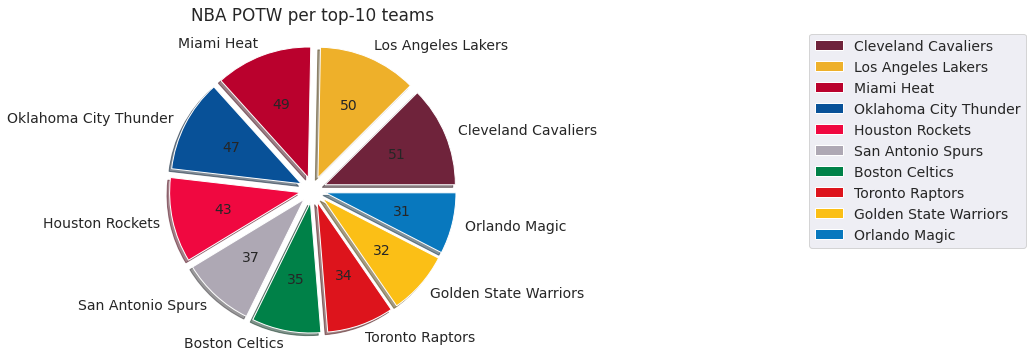

In [15]:
plt.figure(figsize=(12,6))
plt.pie(teams_results.values, labels=teams_results.keys(), autopct=absolute_value, shadow=True,
       colors=["#6f233b", "#eeb02a", "#ba012d", "#085198", "#f00840", 
               "#aea8b4", "#008148", "#dd141c", "#fbbf16", "#0878be"], explode=[0.1] * 10)
plt.legend(loc='upper left', bbox_to_anchor=(2.0, 1.0));
plt.title("NBA POTW per top-10 teams")

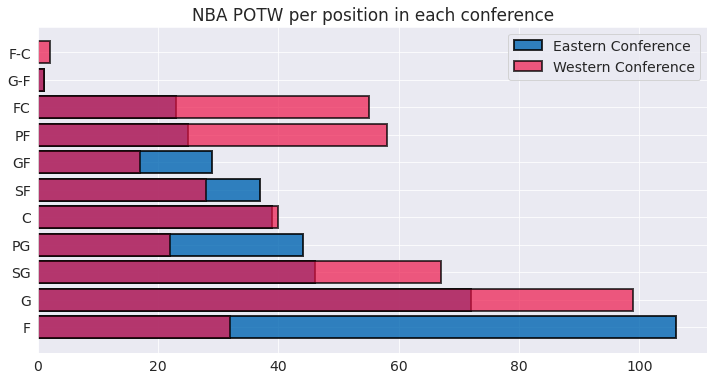

In [16]:
plt.figure(figsize=(12,6))
east_positions = df[df.conference == "East"]["position"].value_counts()
west_positions = df[df.conference == "West"]["position"].value_counts()
plt.barh(east_positions.keys(), east_positions.values, alpha=0.8, 
         color="#0065b2", label="Eastern Conference", linewidth=2, edgecolor="k")
plt.barh(west_positions.keys(), west_positions.values, alpha=0.7,
         color="#ed174b", label="Western Conference", linewidth=2, edgecolor="k")
plt.legend()
plt.title("NBA POTW per position in each conference")
plt.show()

In [17]:
east_age = np.sort(df[df.conference == "East"]["age"].values)
west_age = np.sort(df[df.conference == "West"]["age"].values)
east_seasons_in_league = np.sort(df[df.conference == "East"]["seasons in league"].values)
west_seasons_in_league = np.sort(df[df.conference == "West"]["seasons in league"].values)
east_height = np.sort(df[df.conference == "East"]["height"].values)
west_height = np.sort(df[df.conference == "West"]["height"].values)
east_weight = np.sort(df[df.conference == "East"]["weight"].values)
west_weight = np.sort(df[df.conference == "West"]["weight"].values)

In [18]:
plot_data = [
    ["NBA POTW age distribution per conference", east_age, west_age, 10],
    ["NBA POTW seasons in league distribution per conference", east_seasons_in_league, west_seasons_in_league, 12],
    ["NBA POTW height distribution per conference", east_height, west_height, 9],
    ["NBA POTW weight distribution per conference", east_weight, west_weight, 10],
]

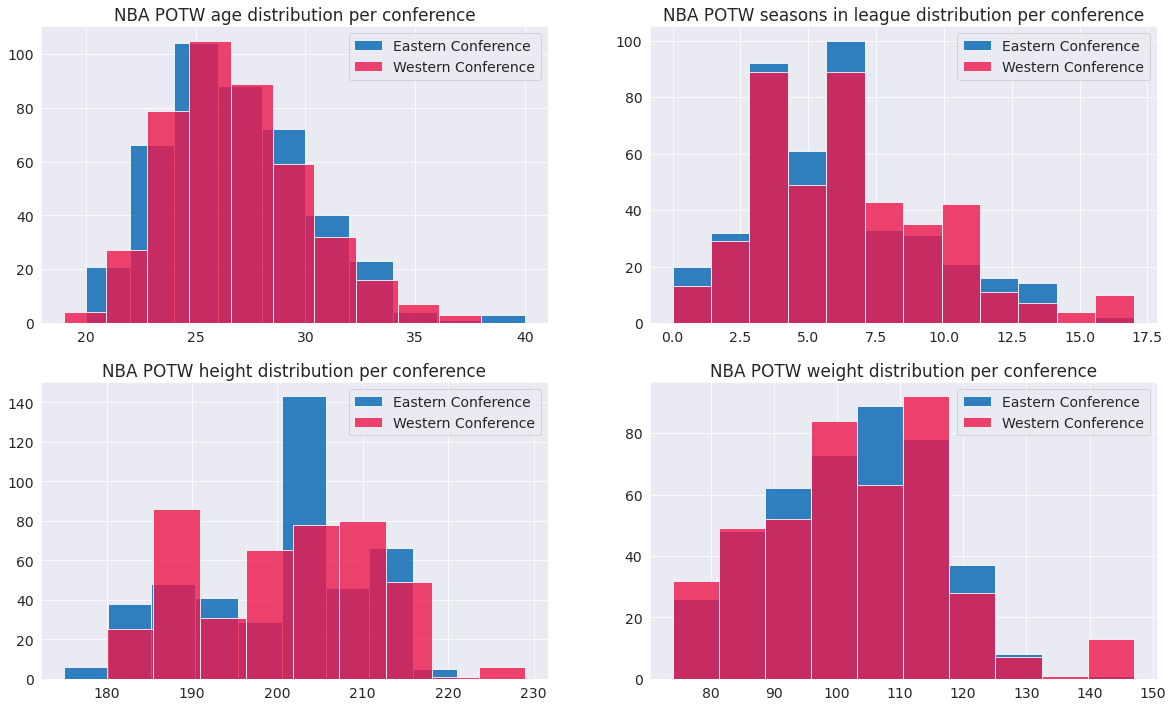

In [19]:
fig, axes = plt.subplots(2, 2, sharex=False, sharey=False, figsize=(20,12))
for i in range(2):
    for j in range(2):
        axes[i, j].set_title(plot_data[2 * i + j][0])
        axes[i, j].hist(plot_data[2 * i + j][1], bins=plot_data[2 * i + j][3], 
                        alpha=0.8, color="#0065b2", label="Eastern Conference")
        axes[i, j].hist(plot_data[2 * i + j][2], bins=plot_data[2 * i + j][3], 
                        alpha=0.8, color="#ed174b", label="Western Conference")
        axes[i, j].legend()

In [20]:
plot_data_east = [
    ["NBA POTW age box-plot (eastern conference)", east_age],
    ["NBA POTW seasons in league box-plot (eastern conference)", east_seasons_in_league],
    ["NBA POTW height box-plot (eastern conference)", east_height],
    ["NBA POTW weight box-plot (eastern conference)", east_weight],
]

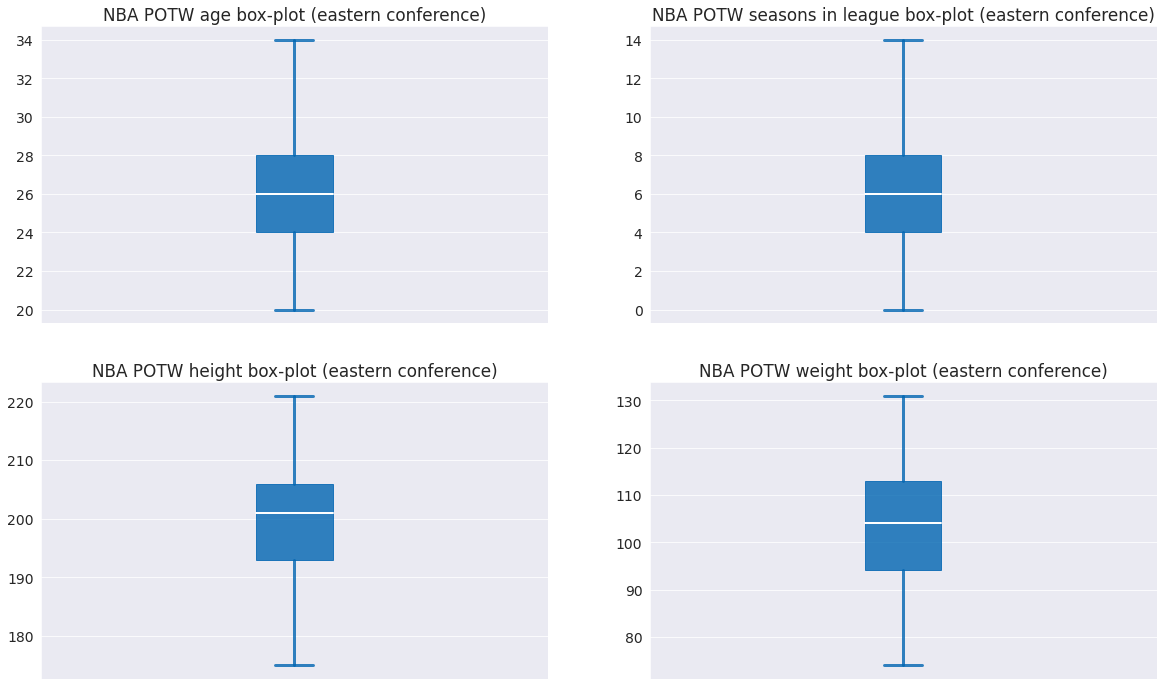

In [21]:
fig, axes = plt.subplots(2, 2, sharex=False, sharey=False, figsize=(20,12))
for i in range(2):
    for j in range(2):
        axes[i, j].set_title(plot_data_east[2 * i + j][0])
        axes[i, j].boxplot(plot_data_east[2 * i + j][1], patch_artist=True, showfliers=False, showmeans=False,
                           boxprops=dict(facecolor="#0065b2", color="#0065b2", alpha=0.8),
                           capprops=dict(color="#0065b2", linewidth=3, alpha=0.8),
                           whiskerprops=dict(color="#0065b2", linewidth=3, alpha=0.8),
                           flierprops=dict(color="#0065b2", markeredgecolor="#0065b2", alpha=0.8),
                           medianprops=dict(color="white", linewidth=2))
        axes[i, j].set_xticks([])

In [22]:
plot_data_west = [
    ["NBA POTW age box-plot (western conference)", west_age],
    ["NBA POTW seasons in league box-plot (western conference)", west_seasons_in_league],
    ["NBA POTW height box-plot (western conference)", west_height],
    ["NBA POTW weight box-plot (western conference)", west_weight],
]

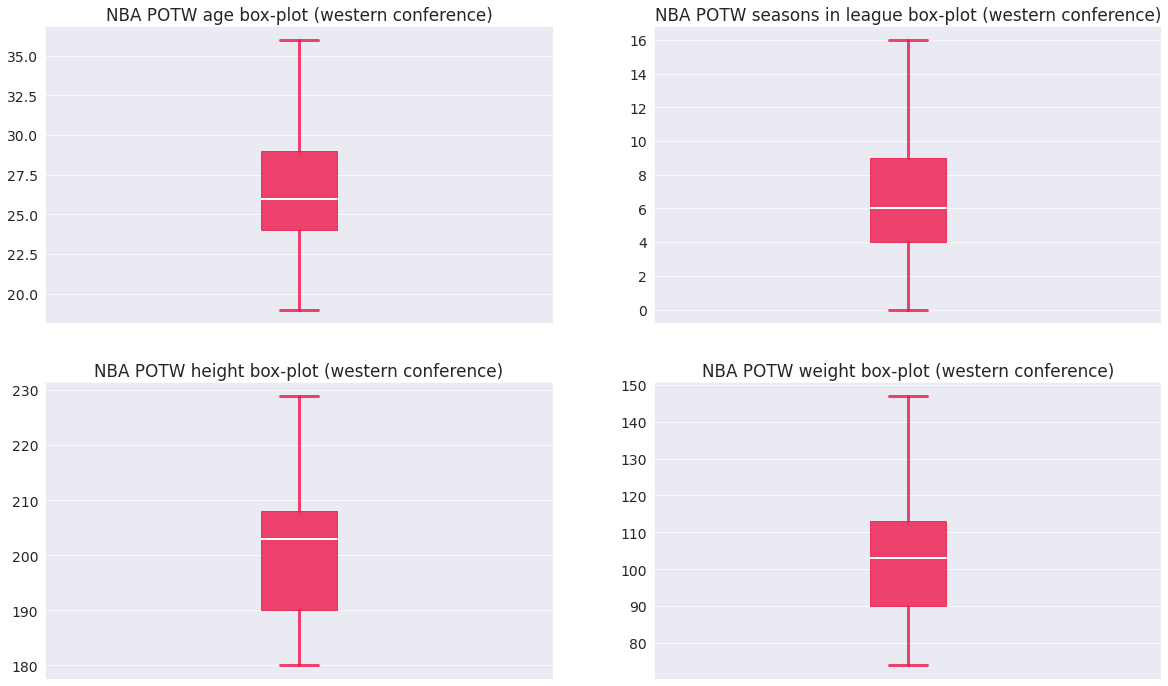

In [23]:
fig, axes = plt.subplots(2, 2, sharex=False, sharey=False, figsize=(20,12))
for i in range(2):
    for j in range(2):
        axes[i, j].set_title(plot_data_west[2 * i + j][0])
        axes[i, j].boxplot(plot_data_west[2 * i + j][1], patch_artist=True, showfliers=False, showmeans=False,
                           boxprops=dict(facecolor="#ed174b", color="#ed174b", alpha=0.8),
                           capprops=dict(color="#ed174b", linewidth=3, alpha=0.8),
                           whiskerprops=dict(color="#ed174b", linewidth=3, alpha=0.8),
                           flierprops=dict(color="#ed174b", markeredgecolor="#ed174b", alpha=0.8),
                           medianprops=dict(color="white", linewidth=2))
        axes[i, j].set_xticks([])

### Вывод по разделу
1) ЛАЛ и Кливленд имеют большой значение количества игроков недели, вероятно, это свзяано с тем, что данные собирались в эпоху Леброна.

2) На Востоке значительный перевес по званиям игроков недели у форвардов, на западе преимущество у гардов; да и в целом значения на позициях отличаются в зависимости от региона, одинаковые количества только у центровых.

3) Ожидаемо, пик количества игроков с рассматриваемым достижением, приходится на 3-7 сезонов в лиге, так как в этот период игроки находятся на пике карьеры.

4) Аналогичные наблюдения и по поводу возраста, но при этом и много возрастных игроков смогли заработать это достижение.

5) В восточной конференции наблюдается большое количество игроков с ростом 200-205 сантиметров, при этом на Западе более равномерное распределение роста.

6) Из box-plot графиков можем сделать гипотезу, что на Западе игроки выше, а вес не отличается в конференциях

7) Также, из box-plot графика выдвигаем гипотезу о том, что в западной конференции доля игроков с ростом ниже среднего выше, чем в восточной

# Проверка статистических гипотез

In [24]:
eastern_conference = df[df.conference == "East"]
western_conference = df[df.conference == "West"]

В первую очередь проверим выборки на независимость. Так как игроки могут переходить между командами, то скорее всего выборки будут зависимы.

Проверим это следующим образом: посмотрим, есть ли одни и те же игроки в обеих конференциях. 

In [25]:
len(set(eastern_conference["player"].values).intersection(set(western_conference["player"].values)))

31

Получается, выборки зависимы. Придется это учитывать

**Замечание**: так как матчи происходят и между командами разных конференций, то выборки заведомо зависимы, так как выступление игроков конференций зависят друг от друга (и, как следствие, попадание в нашу статистику. Пример: если был матч между командами Boston Celtics и Golden State Warriors, в котором победила первая, то, веротность получения звания игрока недели у игроков второй команды ниже)

Количество элементов в выборках:

In [26]:
print(eastern_conference.shape[0], western_conference.shape[0])

422 421


Проверка нужных распределений на нормальность (оформим это в виде гипотез):

1) **H0**: рост, вес и возраст в каждой конференции распределены нормально

**H1**: соответственно, не распределены нормально

2) p_value = 0.05

3) Данных достаточно много, поэтому пользуемся критерием Колмогорова-Смирнова

In [27]:
print("Eastern conference height: ", stats.kstest(east_height, "norm"))
print("Western conference height: ", stats.kstest(west_height, "norm"))
print("Eastern conference weight: ", stats.kstest(east_weight, "norm"))
print("Western conference weight: ", stats.kstest(west_weight, "norm"))
print("Eastern conference age: ", stats.kstest(east_age, "norm"))
print("Western conference age: ", stats.kstest(west_age, "norm"))

Eastern conference height:  KstestResult(statistic=1.0, pvalue=0.0)
Western conference height:  KstestResult(statistic=1.0, pvalue=0.0)
Eastern conference weight:  KstestResult(statistic=1.0, pvalue=0.0)
Western conference weight:  KstestResult(statistic=1.0, pvalue=0.0)
Eastern conference age:  KstestResult(statistic=1.0, pvalue=0.0)
Western conference age:  KstestResult(statistic=1.0, pvalue=0.0)


Получается, **H0** отвергается, распределения нельзя считать нормальным

Теперь мы знаем все, что нам потребуется для определения, какой критерий выбирать. Перейдем к гипотезам

### Параметрический критерий
1) Первая гипотеза

**H0**: Доли игроков, рост которых меньше среднего, в восточной и западной конференциях равны

**H1**: Доля игроков, рост которых меньше среднего, в западной конференции выше

2) Вторая гипотеза

**H0**: Доли гардов, получивших звания игрока недели, в восточной и западной конференциях равны

**H1**: Доля гардов, получивших звания игрока недели, в западной конференции выше


**Замечание**: Остальные гипотезы, сформулированные в выводах к визуальному анализу данных, будут проверены непараметрическим способом, так как наши данные зависимы и не распределены нормально, следовательно, параметрический критерий использовать нельзя

**Замечание**: Гипотезы о позициях, кроме гардов, проверить не вышло, так как мало данных, а выборки зависимы

p_value = 0.05

Для проверки всех гипотез будем использовать двувыборочный критерий с большим числом наблюдений для зависимых выборок

In [28]:
def proportions_diff_z_stat_rel(sample1, sample2):
    sample = zip(sample1, sample2)
    n = len(sample1)
    f = sum([1 if (x[0] == 1 and x[1] == 0) else 0 for x in sample])
    g = sum([1 if (x[0] == 0 and x[1] == 1) else 0 for x in sample])
    return float(f - g) / np.sqrt(f + g - float((f - g) ** 2) / n )

def proportions_diff_z_test(z_stat, alternative = 'two-sided'):
    if alternative == 'two-sided':
        return z_stat, 2 * (1 - stats.norm.cdf(np.abs(z_stat)))
    if alternative == 'less':
        return z_stat, stats.norm.cdf(z_stat)
    if alternative == 'greater':
        return z_stat, 1 - stats.norm.cdf(z_stat)

**Первая гипотеза**

In [29]:
east_proportion = eastern_conference['height'].values < np.mean(eastern_conference['height'].values)
east_proportion = east_proportion.astype('int')
west_proportion = western_conference['height'].values < np.mean(western_conference['height'].values)
west_proportion = west_proportion.astype('int')

In [30]:
proportions_diff_z_test(proportions_diff_z_stat_rel(west_proportion, east_proportion), 'greater')

(14.173857823967161, 0.0)

**Вывод:** на уровне p_value = 0.05, исходя из данных, мы отклоняем гипотезу **H0** в пользу альтернативной, то есть считаем, что доля игроков, рост которых меньше среднего, в западной конференции выше

**Вторая гипотеза**

In [31]:
east_proportion = eastern_conference['position'].values == "G"
east_proportion = east_proportion.astype('int')
west_proportion = western_conference['position'].values  == "G"
west_proportion = west_proportion.astype('int')

In [32]:
proportions_diff_z_test(proportions_diff_z_stat_rel(west_proportion, east_proportion), 'greater')

(10.091323414675948, 0.0)

**Вывод:** на уровне p_value = 0.05, исходя из данных, мы отклоняем гипотезу **H0** в пользу альтернативной, то есть считаем, что доля гардов, получавших звание игрока недели, в западной конференции выше

### Непараметрический критерий

В непараметрических критериях у нас более интереные гипотезы, так как у нас довольно сложные данные: отсутствует нормальность распределений и данные связаны

Сформулируем гипотезы:

1) Первая гипотеза:

**H0**: Рост игроков в западной и восточной конференциях распределен одинаково

**H1**: Игроки западной конференции выше

2) Вторая гипотеза:

**H0**: Вес игроков не зависит от конференции

**H1**: Вес игроков зависит от конференции

3) Третья гипотеза:

**H0**: Средний возраст игроков, получивших звание лучшего на неделе, равняется 26.5 годам

**H1**: Средний возраст игроков, получивших звание лучшего на неделе, равняется 26.5 годам

p_value считаем равным 0.05


**Первая гипотеза**

Используем критерий Уилкоксона для связных выборок

Поскольку нам нужно, чтобы длины выборок совпадали, удалим из востоной конференции одно случайное значение

In [33]:
mask = np.ones(len(east_height), dtype=bool)
mask[np.random.randint(0, len(east_height))] = False
east_height = east_height[mask]

In [34]:
stats.wilcoxon(west_height, east_height, alternative="greater")

WilcoxonResult(statistic=32951.0, pvalue=1.0429583133235857e-24)

**Вывод:** на уровне p_value = 0.05, исходя из данных, мы отклоняем гипотезу **H0** в пользу альтернативной, то есть считаем, что игроки западной конференции выше

**Вторая гипотеза**

Сделаем все аналогично первой

In [35]:
mask = np.ones(len(east_weight), dtype=bool)
mask[np.random.randint(0, len(east_weight))] = False
east_weight = east_weight[mask]

In [36]:
stats.wilcoxon(west_weight, east_weight, alternative="two-sided")

WilcoxonResult(statistic=12600.0, pvalue=0.12330215668805104)

**Вывод:** на уровне p_value = 0.05, исходя из данных, мы не можем отклонить гипотезу **H0**, то есть считаем, что вес игроков не зависит от конференции

**Третья гипотеза**

Используем одновыборочный ранговый критерий Уилкоксона

In [37]:
stats.wilcoxon(df["age"].values - 26.5, alternative="two-sided")

WilcoxonResult(statistic=171261.5, pvalue=0.34778449946465584)

**Вывод**: на уровне p_value = 0.05, исходя из данных, мы не можем отклонить гипотезу H0, то есть считаем, что средний возраст игроков со званием лучшего игрока недели составляет 26.5 лет

Ради интереса найдем доверительный интервал


In [38]:
import statsmodels.stats.api as sms
t = sms.DescrStatsW(df["age"].values)
t.tconfint_mean(alpha=0.05, alternative='two-sided')

(26.333212198373097, 26.78897048252845)

То есть с вероятностью 0.95 игроки со званием лучшего недели имеют возраст между 26 и 27

## Выводы по разделу

1) В западной конференции более рослые игроки, вес игроков распределн одинаково, но из этого все еще можно сделать вывод, что на западе играют в более силовой баскетбол

2) У западной конференции нижняя часть "хвоста" в распределении весов более весомая, чем у восточной

3) На западе гарды получают рассматриваемую награду чаще чем на востоке

4) Средний возраст игроков, получивших звание лучшего недели находится между 26 и 27 годами


# Предсказание временного ряда

Рост и вес игроков во многом определяет их стиль игры, так как более мощные игроки в основном используют более силовую игру, менее рослые же в основном полагаются на технику и дальний бросок. Основная задача - посмотреть характеристики временного ряда и предсказать, какая игровая парадигма нас ждет дальше, исходя из данных предположений

In [39]:
df["date"] = pd.to_datetime(df["date"], format="%b %d, %Y")

In [40]:
eastern_timeseries = df[df.conference == "East"][["date", "height", "weight"]]
western_timeseries = df[df.conference == "West"][["date", "height", "weight"]]
eastern_timeseries.index = eastern_timeseries["date"]
western_timeseries.index = western_timeseries["date"]
eastern_timeseries.sort_index(inplace=True)
western_timeseries.sort_index(inplace=True)

Посмотрим на STL декомпозиции рядов

In [41]:
import statsmodels.api as sm
from pylab import rcParams
rcParams['figure.figsize'] = 12, 7

Text(0.5, 0.98, 'Eastern coference height')

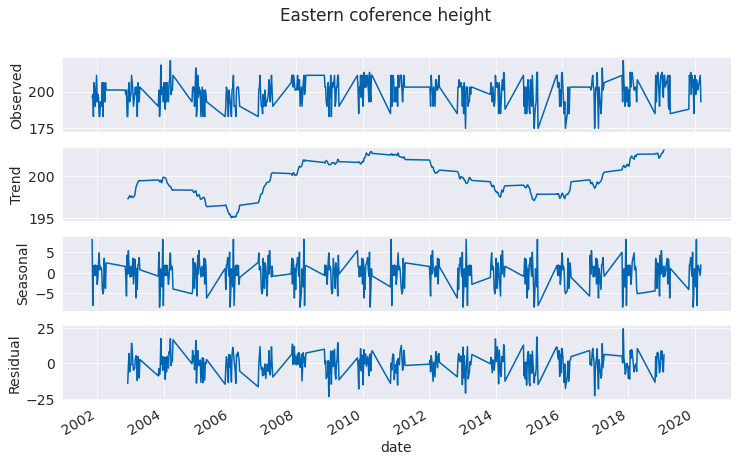

In [42]:
result = sm.tsa.seasonal_decompose(eastern_timeseries.height, model='additive', period=52)
fig, axes = plt.subplots(4, 1, sharex=True)
result.observed.plot(ax=axes[0], legend=False, color='#0065b2')
axes[0].set_ylabel('Observed')
result.trend.plot(ax=axes[1], legend=False, color='#0065b2')
axes[1].set_ylabel('Trend')
result.seasonal.plot(ax=axes[2], legend=False, color='#0065b2')
axes[2].set_ylabel('Seasonal')
result.resid.plot(ax=axes[3], legend=False, color='#0065b2')
axes[3].set_ylabel('Residual')
fig.suptitle("Eastern coference height")

Text(0.5, 0.98, 'Eastern coference weight')

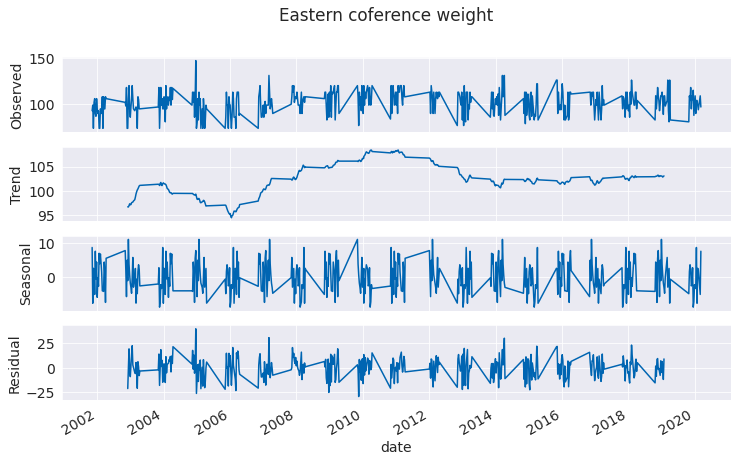

In [43]:
result = sm.tsa.seasonal_decompose(eastern_timeseries.weight, model='additive', period=52)
fig, axes = plt.subplots(4, 1, sharex=True)
result.observed.plot(ax=axes[0], legend=False, color='#0065b2')
axes[0].set_ylabel('Observed')
result.trend.plot(ax=axes[1], legend=False, color='#0065b2')
axes[1].set_ylabel('Trend')
result.seasonal.plot(ax=axes[2], legend=False, color='#0065b2')
axes[2].set_ylabel('Seasonal')
result.resid.plot(ax=axes[3], legend=False, color='#0065b2')
axes[3].set_ylabel('Residual')
fig.suptitle("Eastern coference weight")

Text(0.5, 0.98, 'Western coference height')

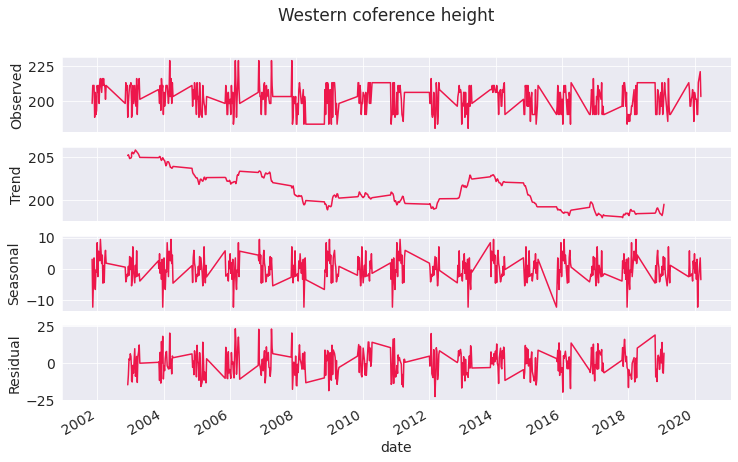

In [44]:
result = sm.tsa.seasonal_decompose(western_timeseries.height, model='additive', period=52)
fig, axes = plt.subplots(4, 1, sharex=True)
result.observed.plot(ax=axes[0], legend=False, color='#ed174b')
axes[0].set_ylabel('Observed')
result.trend.plot(ax=axes[1], legend=False, color='#ed174b')
axes[1].set_ylabel('Trend')
result.seasonal.plot(ax=axes[2], legend=False, color='#ed174b')
axes[2].set_ylabel('Seasonal')
result.resid.plot(ax=axes[3], legend=False, color='#ed174b')
axes[3].set_ylabel('Residual')
fig.suptitle("Western coference height")

Text(0.5, 0.98, 'Western coference weight')

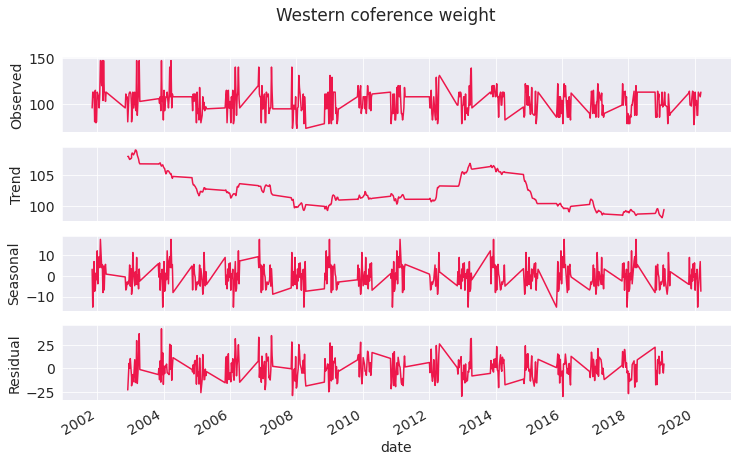

In [45]:
result = sm.tsa.seasonal_decompose(western_timeseries.weight, model='additive', period=52)
fig, axes = plt.subplots(4, 1, sharex=True)
result.observed.plot(ax=axes[0], legend=False, color='#ed174b')
axes[0].set_ylabel('Observed')
result.trend.plot(ax=axes[1], legend=False, color='#ed174b')
axes[1].set_ylabel('Trend')
result.seasonal.plot(ax=axes[2], legend=False, color='#ed174b')
axes[2].set_ylabel('Seasonal')
result.resid.plot(ax=axes[3], legend=False, color='#ed174b')
axes[3].set_ylabel('Residual')
fig.suptitle("Western coference weight")

Из интересного отметим, что временные ряды роста и веса очень похожи, но в различных конференциях имеется разный тренд: на Востоке с 2016 появился тренд, что игроки становятся выше, а на Западе наоборот - ниже! При этом в западной конференции вес тенденция у веса аналогично, а в восточный вес скорее вышел на плато. Построим прогноз роста игроков в каждой из конференций

1) Для прогноза в восточной используем просто метод плавающего среднего, на основе последних 104 недель (двух лет)

2) Для прогноза в западной модель Хольта-Винтерса

Предсказывать будем на следующие 52 недели

In [46]:
eastern_timeseries = eastern_timeseries[["date", "height"]]
western_timeseries = western_timeseries[["date", "height"]]

In [47]:
weeks_in_year = 52
eastern_train = eastern_timeseries.iloc[:-weeks_in_year]
eastern_val   = eastern_timeseries.iloc[-weeks_in_year:]

western_train = western_timeseries.iloc[:-weeks_in_year]
western_val   = western_timeseries.iloc[-weeks_in_year:]

In [48]:
def plot_forecast(train, val, preds, train_c, val_c, preds_c, title):
    forecast = pd.Series(preds)
    forecast.index = val.index
    plt.figure(figsize=(20,6))
    plt.plot(train.height[-104:], label='train', color=train_c, linewidth=3)
    plt.plot(val.height, label='validation', color=val_c, linewidth=3)
    plt.plot(forecast, '--', label='forecast', color=preds_c, linewidth=3)
    plt.legend()
    plt.title(title)
    plt.show()

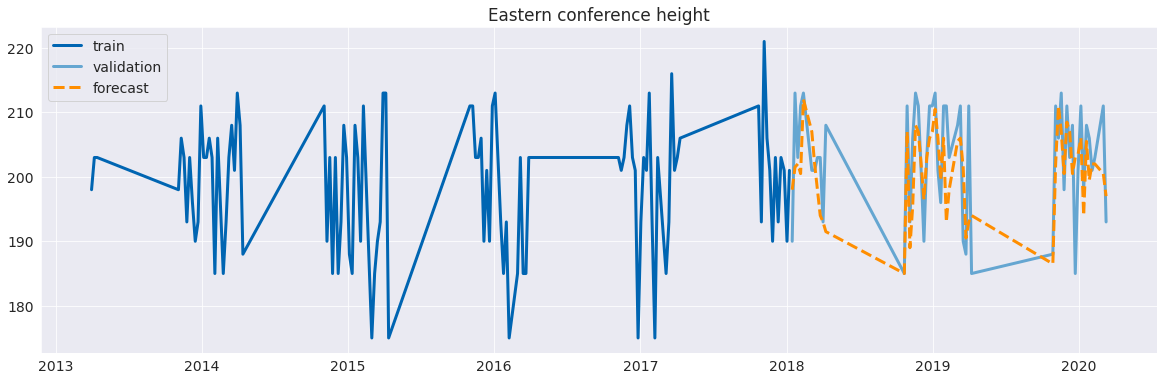

In [49]:
sample = eastern_timeseries[-104:]
preds_arr = np.array(sample.height).reshape(2, -1)
preds = preds_arr.mean(axis = 0)

plot_forecast(eastern_train, eastern_val, preds, '#0065b2', "#65A6D1", "#FF8E00", "Eastern conference height")

In [50]:
from statsmodels.tsa.api import ExponentialSmoothing

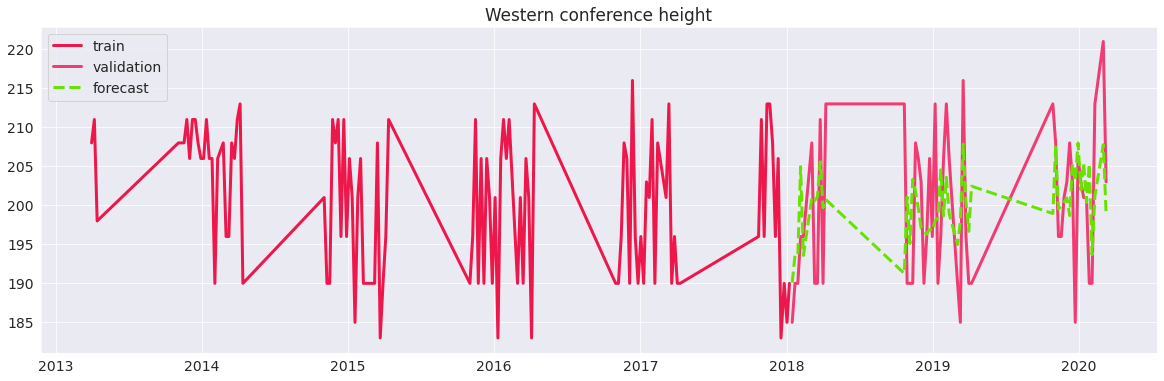

In [72]:
model = ExponentialSmoothing(np.array(western_train.height),
                           seasonal_periods=52, trend='add', seasonal='add').fit(smoothing_level=0.005, 
                                                    smoothing_trend=0.6)
preds = model.forecast(52)

plot_forecast(western_train, western_val, preds, '#ed174b', "#F13C73", "#67E300", "Western conference height")

**Итоги**:

1) Скользящее среднее справилось довольно хорошо с задачей, если не учитывать, что плохо предсказано межсезонье и перерыв на матч всех звезд, но это и ожидаемо, так как в это время не выдаются награды

2) Метод Хольта-Винтерса справился плохо, так как у данных плохая сезонность, нет общего тренда (он имеется на отдельных участках, но уго нет глобадбно) 

# Выводы

1) Главный вывод: западная и восточная конференция сильно отличаются по многим параметрам

2) В Западной конференции игроки в среднем выше, чем в Восточной; веса игроков распределены одинаково

3) В разных конференциях разные позиции получают чаще всех награду лучших игроков недели

4) Тренды на рост игроков в конференциях тоже разные: с 2016го рост лучших игроков Запада уменьшается, Востока увеличивается

5) Больше всего рассматриваемую награду получают игроки в середине своей карьеры как по возрасту, так и по количество сезонов

В итоге можно сказать, что так как награду лучших игроков недели получают в основном звезды своих команд, то исторически на Западе были более рослые игроки, которые определяли более силовую манеру игры, но в последние несколько сезонов в западной конференции появляется тренд на более низких баскетболистов, что говорит о том, что там более активно начинает проявляться тенденция на увелечение техники и дальних бросков. На Востоке же наоборот, увеличивается тренд на более силовую манеру игру. 

**Замечание**: во многом этот список сформирован одними и теми же игроками (например, Леброн Джеймс, Стефан Карри, Янис Антетокунмпо), поэтому совсем глобальных выводов делать нельзя, но в то же время такие игроки и являются определяющими в НБА, следовательно, представленные выводы вполне легитимны.